<a href="https://colab.research.google.com/github/vinicius-vargas/robust-market-screener/blob/main/market_predictors_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q yfinance

In [ ]:
!pip install -q pandas-datareader

In [ ]:
!pip install -q -U scikit-learn==0.23.2

In [ ]:
pip install -q tune-sklearn ray[tune]

Note: you may need to restart the kernel to use updated packages.


In [ ]:
!pip install -q matplotlib

In [ ]:
!pip install -q pandas-profiling==3.1.0

In [ ]:
!pip install -q markupsafe==2.0.1

In [ ]:
!pip install -q autoviz

In [ ]:
!pip install -q pycaret[full]

In [ ]:
!pip install -q BorutaShap

In [ ]:
!pip install -q lightgbm

In [ ]:
!pip install -q shutup

In [ ]:
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

In [ ]:
### Setting up libraries
import numpy as np
import pandas as pd
import yfinance as yf
from pandas_datareader import data as pdr
import warnings
import joblib
import lightgbm as ltb
from BorutaShap import BorutaShap, load_data
from pycaret.datasets import get_data
from pycaret.regression import *
import matplotlib
import shutup;

# Omit Warnings
shutup.please()

# Yahoo Finance Confmplig
yf.pdr_override()

In [ ]:
# Creating factor data
factors = ['mkt', 'size', 'qld', 'momnt', 'liq']

links = [
    'https://nefin.com.br/resources/risk_factors/Market_Factor.xls',
    'https://nefin.com.br/resources/risk_factors/SMB_Factor.xls',
    'https://nefin.com.br/resources/risk_factors/HML_Factor.xls',
    'https://nefin.com.br/resources/risk_factors/WML_Factor.xls',
    'https://nefin.com.br/resources/risk_factors/IML_Factor.xls',
  ]

factors = pd.DataFrame({'factor': factors, 'links': links})

# Loop to bind series into a dataframe
factors_df = pd.DataFrame()
for i in range(len(factors)):
  ret = pd.read_excel(factors['links'][i])  
  factors_df['%s' % factors['factor'][i]] = ret.iloc[:,-1:]

# adjust index
factors_df.index = pd.to_datetime(ret[['year', 'month', 'day']])



# Tickers of Global Indexes
assets = [
          '^VIX',       # Global Volatility Index
          '^TNX',       # Juros 10 anos EUA - BSHV39
          '^IRX',       # Juros 3 meses EUA - BSHV39
          'DX-Y.NYB',   # DXY
          '^GSPC',      # S&P 500 - IVVB11
          'EUR=X',      # USD vs EUR
          'IEV',        # Europa 350 - BIEV39
          'EWJ',        # Top ações Japão - BEWJ39
          'ACWX',       # MSCI - Top Ações mundo ordenado por Cap SEM USA
          'XWD.TO',     # MSCI - Top Ações mundo ordenado por Cap - BURT39
          'XEM.TO',     # MSCI - Ações Emergentes ordenado por Cap - BEEM39
          'EMB',        # USD Emerging Markets Bond
          'CNY=X',      # Remimbi Chines
          '000001.SS',  # Bolsa Chinesa
          'BRL=X',      # USD vs BRL
          'GD=F',       # GSCI ETF commodities - MATB11
          'CL=F',       # Oil
          'GC=F',       # Ouro - GOLD11
          'PETR4.SA', 'VALE3.SA', 'ITUB4.SA', 'BBDC4.SA', 'ELET3.SA', 'BBAS3.SA', 'MGLU3.SA', 
          'B3SA3.SA', 'PRIO3.SA', 'RENT3.SA', 'HAPV3.SA', 'GGBR4.SA', 'ABEV3.SA', 'LREN3.SA', 
          'JBSS3.SA', 'SUZB3.SA', 'WEGE3.SA', 'BPAC11.SA', 'AMER3.SA', 'CSNA3.SA', 'EQTL3.SA', 
          'NTCO3.SA', 'ITSA4.SA', 'VBBR3.SA', 'USIM5.SA', 'RAIL3.SA', 'VIIA3.SA', 'BRFS3.SA', 
          'RDOR3.SA', 'TOTS3.SA', 'RRRP3.SA', 'AZUL4.SA', 'HYPE3.SA', 'CSAN3.SA', 'RADL3.SA', 
          'SBSP3.SA', 'BBSE3.SA', 'PETZ3.SA', 'KLBN11.SA', 'MRFG3.SA', 'ASAI3.SA', 'CVCB3.SA', 
          'LWSA3.SA', 'CMIG4.SA', 'ENEV3.SA', 'MULT3.SA', 'CCRO3.SA', 'CPFE3.SA', 'CIEL3.SA', 
          'BRML3.SA', 'GOLL4.SA', 'EMBR3.SA', 'VIVT3.SA', 'GOAU4.SA', 'UGPA3.SA', 'SULA11.SA',
          'ALPA4.SA', 'TAEE11.SA', '^GSPC', 'ENGI11.SA', 'TIMS3.SA', 'BRKM5.SA', 'BEEF3.SA',
          'ARZZ3.SA', 'CYRE3.SA', 'XPBR31.SA', 'SANB11.SA', 'MRVE3.SA', 'COGN3.SA',
          'EGIE3.SA', 'CRFB3.SA', 'ENBR3.SA', 'CPLE6.SA', 'RAIZ4.SA', 'SMTO3.SA', 'SOMA3.SA',
          'IGTI11.SA', 'CBAV3.SA', 'CASH3.SA', 'YDUQ3.SA', 'PCAR3.SA', 'OIBR3.SA', 'MOVI3.SA',
          'AURE3.SA', 'IRBR3.SA', 'TRPL4.SA', 'MDIA3.SA', 'ENAT3.SA', 'DXCO3.SA', 'MEGA3.SA',
          'QUAL3.SA', 'VAMO3.SA', 'RECV3.SA', 'BPAN4.SA', 'INTB3.SA', 'CMIN3.SA', 'FLRY3.SA',
          'NEOE3.SA', 'ALSO3.SA', 'ALUP11.SA', 'EZTC3.SA', 'PSSA3.SA', 'DMMO3.SA', 'ECOR3.SA',
          'AMBP3.SA', 'LIGT3.SA', 'SBFG3.SA', 'SIMH3.SA', 'GMAT3.SA', 'STBP3.SA', 'SEQL3.SA',
          'UNIP6.SA', 'RAPT4.SA', 'MYPK3.SA', 'SAPR11.SA', 'VIVA3.SA', 'TUPY3.SA', 'LJQQ3.SA',
          'BRPR3.SA', 'BRSR6.SA', 'GGPS3.SA', 'JHSF3.SA', 'CSMG3.SA', 'SMFT3.SA', 'CXSE3.SA',
          'POSI3.SA', 'AGRO3.SA', 'DIRR3.SA', 'TEND3.SA', 'SQIA3.SA', 'AESB3.SA', 'CEAB3.SA',
          'TASA4.SA', 'ANIM3.SA', 'BKBR3.SA', 'ORVR3.SA', 'ESPA3.SA', 'CAML3.SA', 'FESA4.SA',
          'KEPL3.SA', 'TRAD3.SA', 'GRND3.SA', 'ETER3.SA', 'BLAU3.SA', 'AMAR3.SA', 'ODPV3.SA',
          'LOGN3.SA', 'HBSA3.SA', 'ONCO3.SA', 'GUAR3.SA', 'POMO4.SA', 'FHER3.SA', 'WIZS3.SA',
          'RANI3.SA', 'GFSA3.SA', 'AERI3.SA', 'BOAS3.SA', 'CURY3.SA', 'MILS3.SA', 'MLAS3.SA',
          'AALR3.SA', 'JALL3.SA', 'LOGG3.SA', 'TTEN3.SA', 'EVEN3.SA', 'LEVE3.SA', 'PNVL3.SA',
          'PARD3.SA', 'PGMN3.SA', 'CLSA3.SA', 'ARML3.SA', 'BMOB3.SA', 'TRIS3.SA', 'DASA3.SA',
          'PTBL3.SA', 'MODL11.SA', 'LAVV3.SA', 'IFCM3.SA', 'ROMI3.SA', 'PORT3.SA', 'MATD3.SA',
          'VULC3.SA', 'MBLY3.SA', 'DESK3.SA', 'MEAL3.SA', 'ENJU3.SA', 'SOJA3.SA', 'SEER3.SA',
          'TFCO4.SA', 'GETT11.SA', 'TGMA3.SA', 'FRAS3.SA', 'VITT3.SA', 'SYNE3.SA', 'LVTC3.SA',
          'VLID3.SA', 'JSLG3.SA', 'RCSL3.SA', 'VVEO3.SA', 'OPCT3.SA', 'FIQE3.SA', 'LUPA3.SA',
          'VIVR3.SA', 'ELMD3.SA', 'DEXP3.SA', 'NGRD3.SA', 'HBOR3.SA', 'MTRE3.SA', 'BRBI11.SA',
          'PLPL3.SA', 'LPSB3.SA', 'INEP3.SA', 'BMGB4.SA', 'APER3.SA', 'BRIT3.SA', 'CSED3.SA',
          'TECN3.SA', 'WEST3.SA', 'SHUL4.SA',  'LAND3.SA', 'SHOW3.SA', 'ALLD3.SA', 'TCSA3.SA',
          'NINJ3.SA', 'PDGR3.SA', 'KRSA3.SA', 'STOC31.SA', 'TPIS3.SA', 'PRNR3.SA', 'AZEV4.SA',
          'ALPK3.SA', 'MELK3.SA', 'PMAM3.SA', 'LLIS3.SA', 'RSID3.SA', 'COCE5.SA', 'RNEW4.SA',
          'DMVF3.SA', 'G2DI33.SA', 'EUCA4.SA', 'CGRA4.SA', 'CLSC4.SA', 'MOAR3.SA', 'CRPG5.SA',
          'CEBR6.SA', 'HBRE3.SA', 'OFSA3.SA', 'PDTC3.SA', 'SGPS3.SA', 'UCAS3.SA', 'DOTZ3.SA',
          'EMAE4.SA', 'PINE4.SA', 'BLUT4.SA'
          ]
assets.sort()

# Date Range
start = '2006-01-01'
end = factors_df.index[-1].strftime('%Y-%m-%d')

# Downloading data
data = pdr.get_data_yahoo(assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))].droplevel(level=0, axis=1)

# Join both datasets into one
data = pd.concat([data.pct_change(), factors_df], axis = 1)

# Turn all values from lognormal to normal
final_data = np.log1p(data)

[*********************100%***********************]  271 of 271 completed


In [ ]:
# Get market potential predictors
factors = [
    '^TNX',         # Juros 10 anos EUA - BSHV39
    '^IRX',         # Juros 3 meses EUA - BSHV39
    'DX-Y.NYB',     # DXY
    '^VIX',         # Global Volatility Index
    '^GSPC',        # S&P 500 - IVVB11
    'EUR=X',        # USD vs EUR
    'IEV',          # Europa 350 - BIEV39
    'EWJ',          # Top ações Japão - BEWJ39
    'ACWX',       # MSCI - Top Ações mundo ordenado por Cap SEM USA
    'XWD.TO',       # MSCI - Top Ações mundo ordenado por Cap - BURT39
    'XEM.TO',       # MSCI - Ações Emergentes ordenado por Cap - BEEM39
    'EMB',          # USD Emerging Markets Bond
    'CNY=X',        # Remimbi Chines
    '000001.SS',    # Bolsa Chinesa
    'GD=F',         # GSCI ETF commodities - MATB11
    'CL=F',         # Oil
    'GC=F',         # Ouro - GOLD11
    'BRL=X',        # USD vs BRL
    'mkt',
    'size',
    'qld',
    'momnt',
    'liq'
]

# Create dataframe to save alpha and betas
final_data = pd.DataFrame()

# Run a linear regression to get alpha
for i in [x for x in assets if x not in factors]:

  # Select index by Ticker Name
  y = data[i].dropna()

  # Selecting factors
  # Make Sure X index equals to Y Index
  x = data[data.index.isin(y.index)][factors].dropna()
  
  # Make Sure Y index equals to X indes
  y = y[y.index.isin(x.index)]

  # Creates a unique dataframe
  df = pd.concat([y, x], axis = 1)

  # Rename the first column name
  df.rename(columns={df.columns[0]: "RET" }, inplace = True)

  # Append in initial dataframe
  final_data = final_data.append(df)


final_data.head(3)

,RET,^TNX,^IRX,DX-Y.NYB,^VIX,^GSPC,EUR=X,IEV,EWJ,ACWX,XWD.TO,XEM.TO,EMB,CNY=X,000001.SS,GD=F,CL=F,GC=F,BRL=X,mkt,size,qld,momnt,liq
2016-10-31,-0.059375,-0.005962,0.080586,0.001017,0.053737,-0.000122,-0.007674,-0.001048,0.000792,0.000982,0.003140,0.008976,0.001047,-0.000206,-0.001217,-0.022967,-0.037782,-0.003136,0.011942,0.006591,-0.003893,-0.004295,0.000189,-0.010828
2016-11-01,-0.008859,-0.007634,0.169492,-0.007618,0.087925,-0.006787,0.001033,-0.004458,-0.003959,-0.003926,-0.007705,-0.012811,-0.001023,-0.001297,0.007078,-0.001798,-0.004055,0.011718,-0.001530,-0.025070,-0.001421,0.002467,-0.017427,0.002277
2016-11-03,0.005028,0.007226,0.037681,-0.002464,0.142857,-0.004423,-0.003649,-0.002122,0.002400,-0.001243,-0.005121,0.000366,0.002631,-0.002838,0.008445,-0.008583,-0.014998,-0.003597,0.005409,-0.024593,0.002152,-0.007016,-0.000170,0.004614


In [ ]:
### Run a model optimization pipeline using Pycaret
###################################################

### Starting Experiment
st_exp = setup(
    # Default params
    session_id=123,
    silent=True,

    # Data configs
    data=final_data,
    train_size=0.7,
    target='RET',
    
    # Dealing with outliers
    remove_outliers=True
)

# Run Model Comparision
best_model = compare_models(
    exclude = ['catboost', 'et', 'gbr'],
    sort = 'R2'
)

print(best_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.0177,0.0011,0.0328,0.0973,0.0257,1.6575,0.8710
xgboost,Extreme Gradient Boosting,0.0177,0.0011,0.0329,0.0957,0.0256,1.7572,11.2720
lr,Linear Regression,0.0178,0.0011,0.0329,0.0943,0.0256,1.8126,0.3690
br,Bayesian Ridge,0.0178,0.0011,0.0329,0.0943,0.0256,1.8112,0.1220
ridge,Ridge Regression,0.0178,0.0011,0.0329,0.0942,0.0257,1.7748,0.0360
lar,Least Angle Regression,0.0178,0.0011,0.0329,0.0942,0.0257,1.7963,0.0400
dt,Decision Tree Regressor,0.0178,0.0011,0.0329,0.0938,0.0255,1.8970,0.5330
rf,Random Forest Regressor,0.0178,0.0011,0.0329,0.0936,0.0255,1.8342,32.3950
omp,Orthogonal Matching Pursuit,0.0178,0.0011,0.0329,0.0928,0.0257,1.7857,0.0410
huber,Huber Regressor,0.0177,0.0011,0.0329,0.0914,0.0260,1.7149,1.5540


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [ ]:
final_model = create_model('lightgbm')      # lightgbm because it's fast

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0176,0.0009,0.0302,0.1073,0.0254,1.5604
1,0.0176,0.0009,0.0292,0.1199,0.0248,1.5820
2,0.0176,0.0009,0.0304,0.1069,0.0255,1.5676
3,0.0177,0.0010,0.0314,0.0984,0.0256,1.8740
4,0.0179,0.0014,0.0376,0.0758,0.0275,1.4941
5,0.0177,0.0011,0.0328,0.0872,0.0261,1.5957
6,0.0174,0.0009,0.0295,0.1098,0.0247,2.1863
7,0.0179,0.0024,0.0485,0.0440,0.0274,1.5107
8,0.0174,0.0008,0.0282,0.1119,0.0240,1.5099


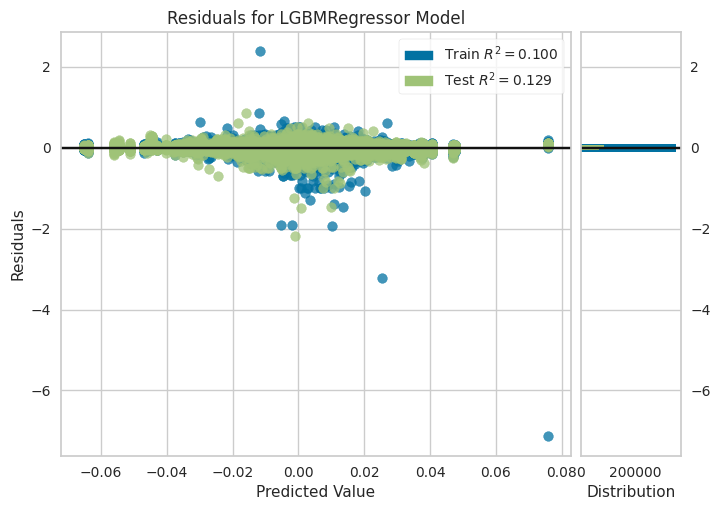

In [ ]:
plot_model(final_model, plot = 'residuals')

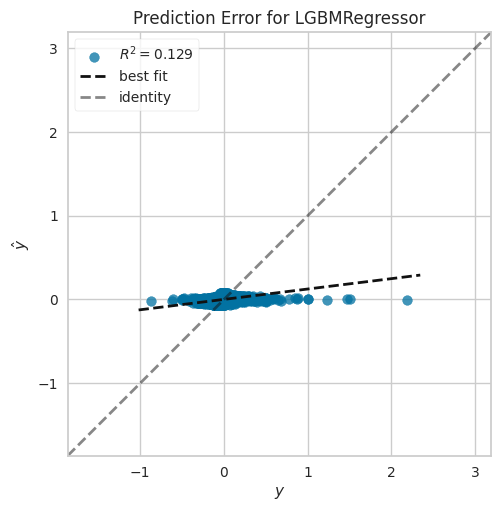

In [ ]:
plot_model(final_model, plot = 'error')

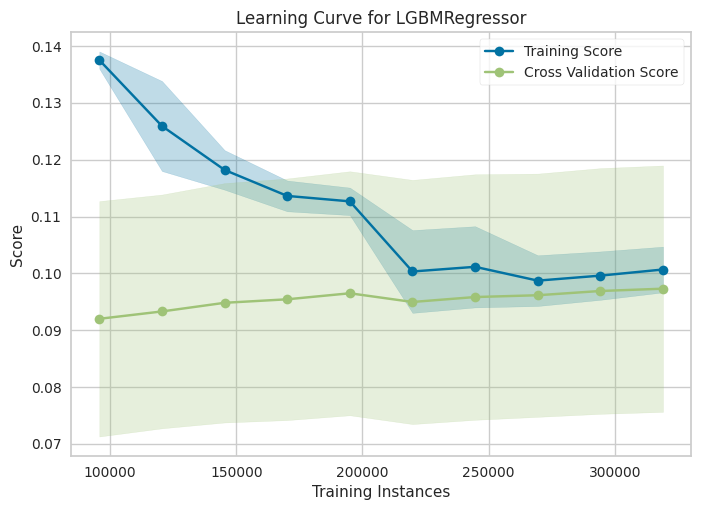

In [ ]:
plot_model(final_model, plot = 'learning')

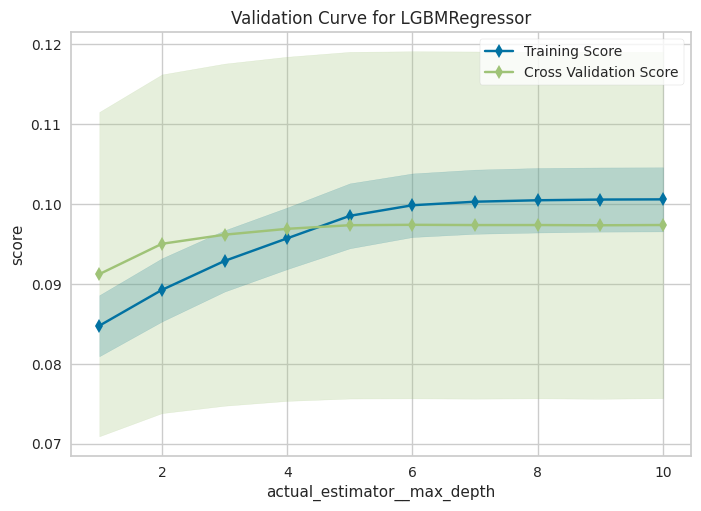

In [ ]:
plot_model(final_model, plot = 'vc')

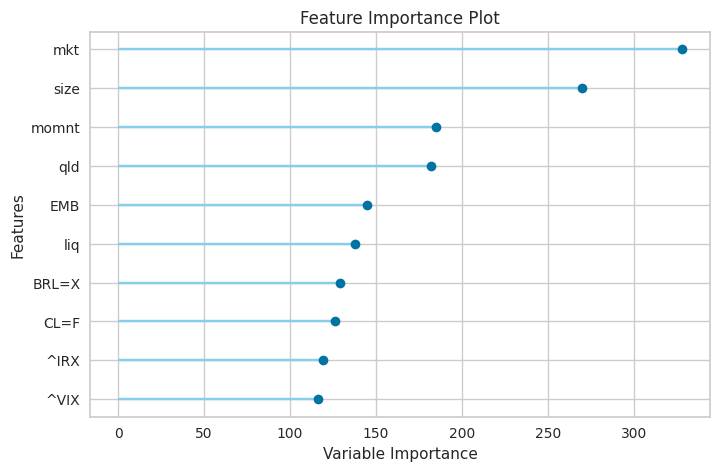

In [ ]:
plot_model(final_model, plot = 'feature')

In [ ]:
X_train = get_config('X_train')

print(len(X_train.columns))

23


In [ ]:
X_train.columns

Index(['^TNX', '^IRX', 'DX-Y.NYB', '^VIX', '^GSPC', 'EUR=X', 'IEV', 'EWJ', 'ACWX', 'XWD.TO', 'XEM.TO', 'EMB', 'CNY=X', '000001.SS', 'GD=F', 'CL=F', 'GC=F', 'BRL=X', 'mkt', 'size', 'qld', 'momnt', 'liq'], dtype='object')


10 attributes confirmed important: ['^GSPC', 'mkt', 'size', 'CL=F', 'GD=F', 'BRL=X', 'EMB', 'qld', 'momnt', 'liq']
12 attributes confirmed unimportant: ['ACWX', 'IEV', '^TNX', 'XWD.TO', 'EWJ', 'DX-Y.NYB', '^VIX', 'GC=F', 'XEM.TO', 'EUR=X', '^IRX', '000001.SS']
1 tentative attributes remains: ['CNY=X']


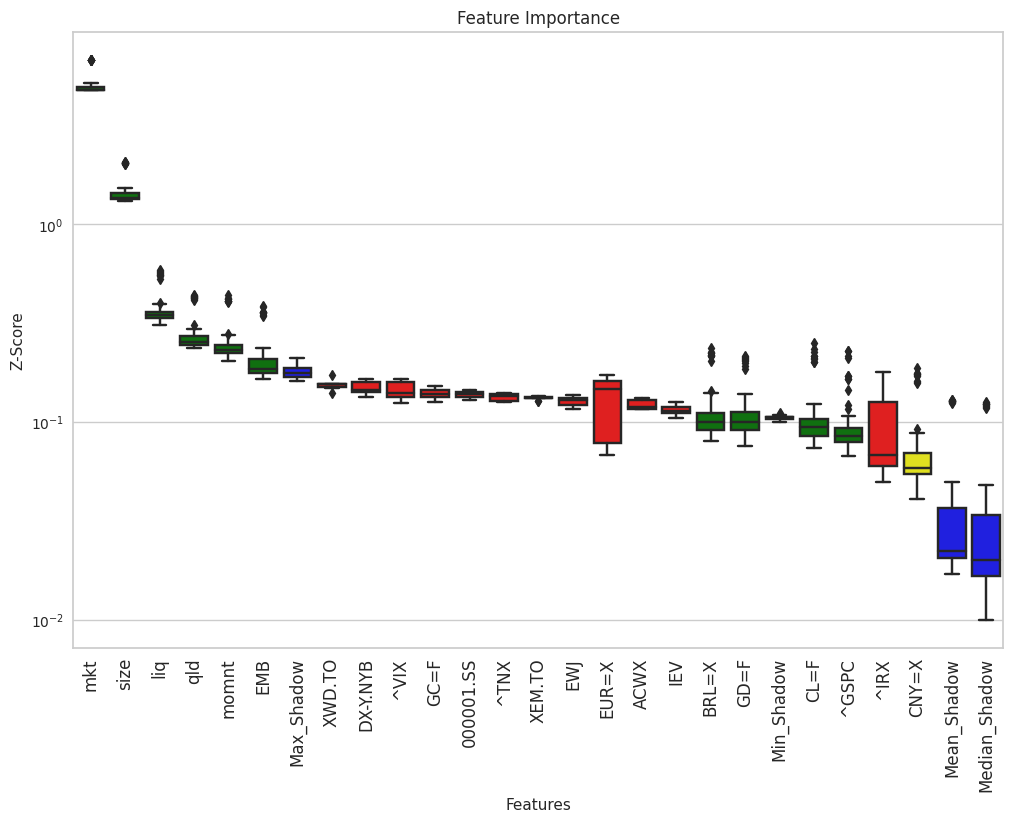

In [ ]:
### Feature Selection with Boruta Shap
######################################

### Using lgbm because it is the fastest forest based model
model = ltb.LGBMRegressor()

x_vars = final_data.iloc[:, 1:]
y_var = final_data['RET']

# model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(
    model=model,
    importance_measure='shap',
    classification=False,
    pvalue=0.05
)

Feature_Selector.fit(
    X=x_vars,
    y=y_var,
    n_trials=100,
    random_state=123,
)


# Returns Boxplot of features
Feature_Selector.plot(
    X_size=12,
    figsize=(12,8),
    y_scale='log',
    which_features='all'
)

In [ ]:
Feature_Selector.Subset().columns

Index(['^GSPC', 'mkt', 'size', 'CL=F', 'GD=F', 'BRL=X', 'EMB', 'qld', 'momnt', 'liq'], dtype='object')

In [ ]:
### Feature Selection with Lasso Regression
###########################################

# use automatically configured the lasso regression algorithm
from numpy import arange
from sklearn.linear_model import Lasso
from sklearn.model_selection import RepeatedKFold

# define model
model = Lasso(
    alpha=0.000001,
    fit_intercept=True
)

# fit model
clf = model.fit(x_vars, y_var)

# Get Coefficients from Lasso Regression
coef = pd.DataFrame(
    {
        'features': pd.Series(x_vars.columns),
        'coef': pd.Series([clf.coef_[i] for i in range(len(clf.coef_))])
    }
)

# Get Intercept from Lasso Regression
interc = pd.DataFrame(
    {
        'features': 'intercept',
        'coef': [clf.intercept_]
    }
)

coef_lasso = interc.append(coef, ignore_index=True)

coef_lasso.sort_values(by=['coef'], inplace=True, ascending=False)

coef_lasso_final = coef_lasso[(coef_lasso.coef > 0)].reset_index(drop=True)

coef_lasso_final

,features,coef
0,mkt,0.857022
1,size,0.437525
2,EMB,0.099699
3,liq,0.074766
4,^GSPC,0.030981
5,XWD.TO,0.014140
6,^VIX,0.002650
7,EUR=X,0.001722
8,intercept,0.000564
9,^IRX,0.000353


In [ ]:
### Saving All relevant features from both algorithms
final_features = pd.DataFrame(
    {
        'features': pd.Series(x_vars.columns),
        'boruta': '',
        'lasso': '',
    }
)

### Loop to test if feature is in Boruta or Lasso Selection
for i in final_features.features:
    if i in Feature_Selector.Subset().columns.values:
        
        final_features.boruta[int(final_features[final_features['features']==i].index.values)] = 'Sim'
    else:
        final_features.boruta[int(final_features[final_features['features']==i].index.values)] = '-'
    
    if i in coef_lasso_final.features.values:
        
        final_features.lasso[int(final_features[final_features['features']==i].index.values)] = 'Sim'
    else:
        final_features.lasso[int(final_features[final_features['features']==i].index.values)] = '-'

### Filter only relevant features from both selections
final_features[(final_features.boruta == 'Sim') | (final_features.lasso == 'Sim')].reset_index(drop=True)

,features,boruta,lasso
0,^IRX,-,Sim
1,^VIX,-,Sim
2,^GSPC,Sim,Sim
3,EUR=X,-,Sim
4,XWD.TO,-,Sim
5,EMB,Sim,Sim
6,GD=F,Sim,-
7,CL=F,Sim,-
8,BRL=X,Sim,-
9,mkt,Sim,Sim
